In [1]:
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregseq

# visualization
import matplotlib.pyplot as plt

## 0. Loading input data

In [2]:
## Loading WT promoter sequence

# Promoter
lacWT = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequences
O1 = 'AATTGTGAGCGGATAACAATT'

_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv('../data/ecoli_gene_list.csv')
lacO1_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
lacO1 = tregseq.seq_utils.get_regulatory_region(genome, lacO1_TSS, reverse=True)

In [3]:
## Loading and fixing the RNAP energy matrix
rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregseq.simulate.fix_wt(rnap_emat_raw, lacWT)

## Loading and fixing the lacI energy matrix
O1_1027_raw = np.load('../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregseq.simulate.fix_wt(O1_1027_raw[i], O1)
O1_emat = np.mean(O1_1027_fixed, axis=0)

## 2. Calculate $p_{\mathrm{bound}}$

In [4]:
n_NS = len(genome)
n_p = 4600
n_r = 10

ep_wt = -5
er_wt = -15
df_1000 = tregseq.simulate.simrep(lacO1, lacWT, O1, rnap_emat, O1_emat, 
                                  ep_wt, er_wt, n_NS, n_p, n_r, num_mutants=1000)
df_1000.head()

,seq,pbound,ct_0,ct_1,ct,norm_ct_1
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.032644,28.076379,92.0,120.076379,3.276776
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.004342,6.158140,3.0,9.158140,0.487160
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.038357,20.537955,79.0,99.537955,3.846537
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.140543,10.904753,154.0,164.904753,14.122283
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAAcTAA...,0.004833,8.120106,4.0,12.120106,0.492604


In [5]:
n_seqs = len(df_1000)
mut_list = df_1000['seq'].values
mu_data = df_1000['norm_ct_1']
nbins = 2
upper_bound = 5
footprint_1000 = tregseq.footprint.get_info_footprint(mut_list, mu_data, lacO1, nbins, upper_bound)

In [6]:
exshift_list_1000 = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, lacO1)
shiftcolors_1000 = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list_1000]

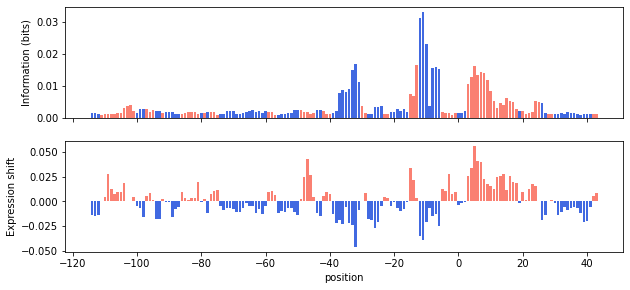

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4.5), sharex=True)
ax1, ax2 = axes

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax1.bar(x, footprint_1000, edgecolor=None, color=shiftcolors_1000)
ax1.set_ylabel('Information (bits)')

ax2.bar(x, exshift_list_1000, edgecolor=None, color=shiftcolors_1000)
ax2.set_ylabel('Expression shift')
ax2.set_xlabel('position')

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()